In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [3]:
path

Path('../input/paddy-disease-classification')

import fast ai vision, set random see and peek through the data

In [4]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

As we se above, the images are in train_images, so lets grab them

In [5]:
train_path = path/'train_images'
files = get_image_files(train_path)

Lets see one example

(480, 640)


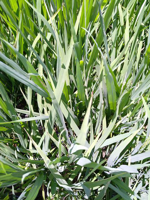

In [6]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(200)

lets check the size of all images to make sure its consistent, it will be much quicker to do so in parallel,so im going to use fastcore parallel

In [7]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes = parallel(f,files, n_workers = 8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

They're nearly all the same size, except for a few. Because of those few, however, we'll need to make sure we always resize each image to common dimensions first, otherwise fastai won't be able to create batches. For now, we'll just squish them to 480x480 images, and then once they're in batches we do a random resized crop down to a smaller size, along with the other default fastai augmentations provided by aug_transforms. We'll start out with small resized images, since we want to be able to iterate quickly:

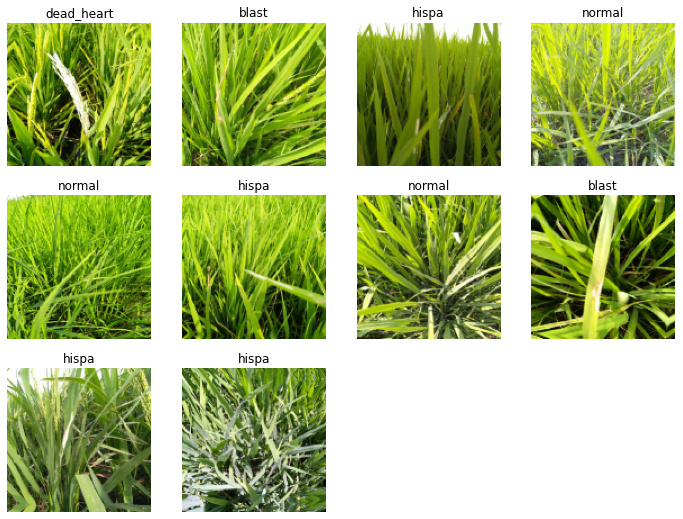

In [8]:
dls = ImageDataLoaders.from_folder(train_path,valid_pct = 0.2, seed=0.42,
                                 item_tfms=Resize(480, method='squish'),
                                 batch_tfms = aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=10)



# First Model
Let's create a model. To pick an architecture, we should look at the options in The best vision models for fine-tuning. I like the looks of resnet26d, which is the fastest resolution-independent model which gets into the top-15 lists there.

In [9]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


lets see what the learning rate finder shows:

SuggestedLRs(valley=0.0014454397605732083, slide=0.002511886414140463)

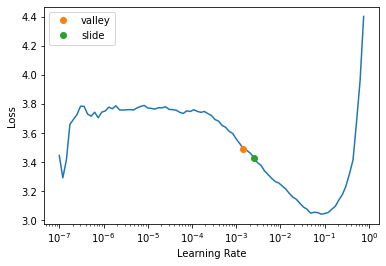

In [10]:
learn.lr_find(suggest_funcs=(valley,slide))

lr_find generally recommends rather conservative learning rates, to ensure that your model will train successfully. I generally like to push it a bit higher if I can. Let's train a few epochs and see how it looks:

In [11]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.725599,1.208215,0.379625,01:47


epoch,train_loss,valid_loss,error_rate,time
0,1.164237,0.726481,0.246997,01:49
1,0.802412,0.416759,0.130226,01:50
2,0.564276,0.355346,0.110043,01:48


In [12]:
s = pd.read_csv(path/'sample_submission.csv')
s

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [13]:
test_files = get_image_files(path/'test_images').sorted()
test_dl = dls.test_dl(test_files)

We can now get the probabilities of each class, and the index of the most likely class, from this test set (the 2nd thing returned by get_preds are the targets, which are blank for a test set, so we discard them):

In [14]:
probs,_,idxs = learn.get_preds(dl=test_dl,with_decoded=True)
idxs

TensorBase([7, 8, 7,  ..., 8, 1, 5])

These need to be mapped to the names of each of these diseases, these names are stored by fastai automatically in the vocab:

In [15]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [16]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(),name='idxs').map(mapping)
results

0                       hispa
1                      normal
2                       hispa
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

turn to csv so we can submit

In [17]:
s['label'] = results
s.to_csv('subm.csv', index=False)
!head subm.

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
